## ANALYZING CHURN USING CLASSIFICATION MODELS

### BUSINESS UNDERSTANDING

#### GOAL  
- The aim of this project is to predict Telco customers possibility of churning

#### DESCRIPTION OF THE DATA  

  
| Feature           | Description                                                |
|-------------------|------------------------------------------------------------| 
| CustomerID           |Unique Identifier of customer                |
| Gender            | Whether the customer is a male or a female                 |
| SeniorCitizen     | Whether a customer is a senior citizen or not              |
| Partner           | Whether the customer has a partner or not (Yes, No)        |
| Dependents        | Whether the customer has dependents or not (Yes, No)       |
| Tenure            | Number of months the customer has stayed with the company |
| Phone Service     | Whether the customer has a phone service or not (Yes, No)  |
| MultipleLines     | Whether the customer has multiple lines or not            |
| InternetService   | Customer's internet service provider (DSL, Fiber Optic, No)|
| OnlineSecurity    | Whether the customer has online security or not (Yes, No, No Internet)|
| OnlineBackup      | Whether the customer has online backup or not (Yes, No, No Internet)|
| DeviceProtection  | Whether the customer has device protection or not (Yes, No, No internet service)|
| TechSupport       | Whether the customer has tech support or not (Yes, No, No internet)|
| StreamingTV       | Whether the customer has streaming TV or not (Yes, No, No internet service)|
| StreamingMovies   | Whether the customer has streaming movies or not (Yes, No, No Internet service)|
| Contract          | The contract term of the customer (Month-to-Month, One year, Two year)|
| PaperlessBilling  | Whether the customer has paperless billing or not (Yes, No)|
| Payment Method    | The customer's payment method (Electronic check, Mailed check, Bank transfer(automatic), Credit card(automatic))|
| MonthlyCharges    | The amount charged to the customer monthly|
| TotalCharges      | The total amount charged to the customer|
| Churn             | Whether the customer churned or not (Yes or No), **target variable**          |


### HYPOTHESIS STATEMENT  

 - Null ($H_0$) : There is no signoficant relationship between Total Charges and Churn.  
 - Alternative ($H_1$) : There is a significant relationship between Total Charges and Churn

### BUSINESS QUESTIONS  

  - What is the gender dynamics in Churn?
  - How does tenure affect Churn?
  - Which gender uses StreamingTV service more?
  - How are gender and tenure distributed among customers, and what impact do these factors have on customer churn?
  - What patterns exist in how contract and total charges affect Churn?


### DATA UNDERSTANDING

In [66]:
# Import all needed libraries
import pandas as pd
import numpy as np
import os
import pyodbc
from sqlalchemy import create_engine
from dotenv import load_dotenv,dotenv_values
from sqlalchemy import create_engine
from urllib.parse import quote_plus
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import chi2_contingency
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import joblib


print('Packages: Ready!')


Packages: Ready!


In [68]:
# Loading environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

# print(environment_variables)

# Getting values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USER")
password = environment_variables.get("PASSWORD")

# Ensure all required variables are present
if not all([server, database, username, password]):
    raise ValueError("Missing one or more required environment variables (SERVER, DATABASE, USER, PASSWORD)")

# Connection string
connection_string = f"DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

# Connecting to the database
try:
    connection = pyodbc.connect(connection_string)
    print("Successfully connected to the database!")
    
    
    cursor = connection.cursor()
    cursor.execute("SELECT @@version;")
    row = cursor.fetchone()
    print("SQL Server version:", row[0])

except pyodbc.Error as e:
    print("Error connecting to the database:", e)


OrderedDict({'SERVER': 'dap-projects-database.database.windows.net', 'USER': 'LP2_project', 'PASSWORD': 'Stat$AndD@t@Rul3', 'DATABASE': 'dapDB'})
Successfully connected to the database!
SQL Server version: Microsoft SQL Azure (RTM) - 12.0.2000.8 
	Oct  2 2024 11:51:41 
	Copyright (C) 2022 Microsoft Corporation



In [3]:
# Loading environment variables from .env file
load_dotenv()

# Getting environment variables
server = os.getenv("SERVER")
database = os.getenv("DATABASE")
username = os.getenv("USER")
password = os.getenv("PASSWORD")

# URL-encode password to handle special characters
encoded_password = quote_plus(password)

# SQLAlchemy connection string
connection_string = f"mssql+pyodbc://{username}:{encoded_password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"

# SQLAlchemy engine
engine = create_engine(connection_string)

# Read data into a pandas DataFrame
query = "SELECT * FROM dbo.LP2_Telco_churn_first_3000"
dn1 = pd.read_sql(query,connection)


C:\Users\Etebom\AppData\Local\Temp\ipykernel_9676\4076349535.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dn1 = pd.read_sql(query,connection)


In [4]:
dn1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [5]:
# Load from GitHub repository source
url = 'https://raw.githubusercontent.com/Azubi-Africa/Career_Accelerator_LP2-Classifcation/main/LP2_Telco-churn-second-2000.csv'


# load the csv file
dn2 = pd.read_csv(url)

dn2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [6]:
# Saving both dataframes as csv files
dn1.to_csv('telco_1.csv', index=False)
dn2.to_csv('telco_2.csv', index=False)

In [7]:
# Loading both files for data manipulation
dat1 = 'telco_1.csv'
dat2 = 'telco_2.csv'

# Creating dataframes
dn1 = pd.read_csv(dat1)
dn2 = pd.read_csv(dat2)

In [8]:
dn1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,NaN,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,NaN,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [9]:
dn2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [10]:
dn1.shape

(3000, 21)

In [11]:
dn2.shape

(2043, 21)

In [12]:
# Concatenating both dataframes
dn = pd.concat([dn1, dn2])

In [13]:
# Saving the contatenated dataframe
dn.to_csv('dn.csv')

In [14]:
dn.shape

(5043, 21)

In [15]:
# Quick overview of dataframe information
dn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 
 17  

In [16]:
dn.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
2039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
2040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
2041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
2042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


In [17]:
dn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,NaN,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,0,False,False,45,False,NaN,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [18]:
# Replacing booleans with objects
dn.replace({True: 'Yes', False: 'No'}, inplace=True)

In [19]:
dn.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
2039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
2040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
2041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
2042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


In [20]:
dn.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,NaN,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,Yes
3,7795-CFOCW,Male,0,No,No,45,No,NaN,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.650002,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.099998,1949.400024,No
7,6713-OKOMC,Female,0,No,No,10,No,NaN,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.750000,301.899994,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.800003,3046.050049,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.150002,3487.949951,No


In [21]:
# Checking count of null values across columns
dn.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

<Axes: >

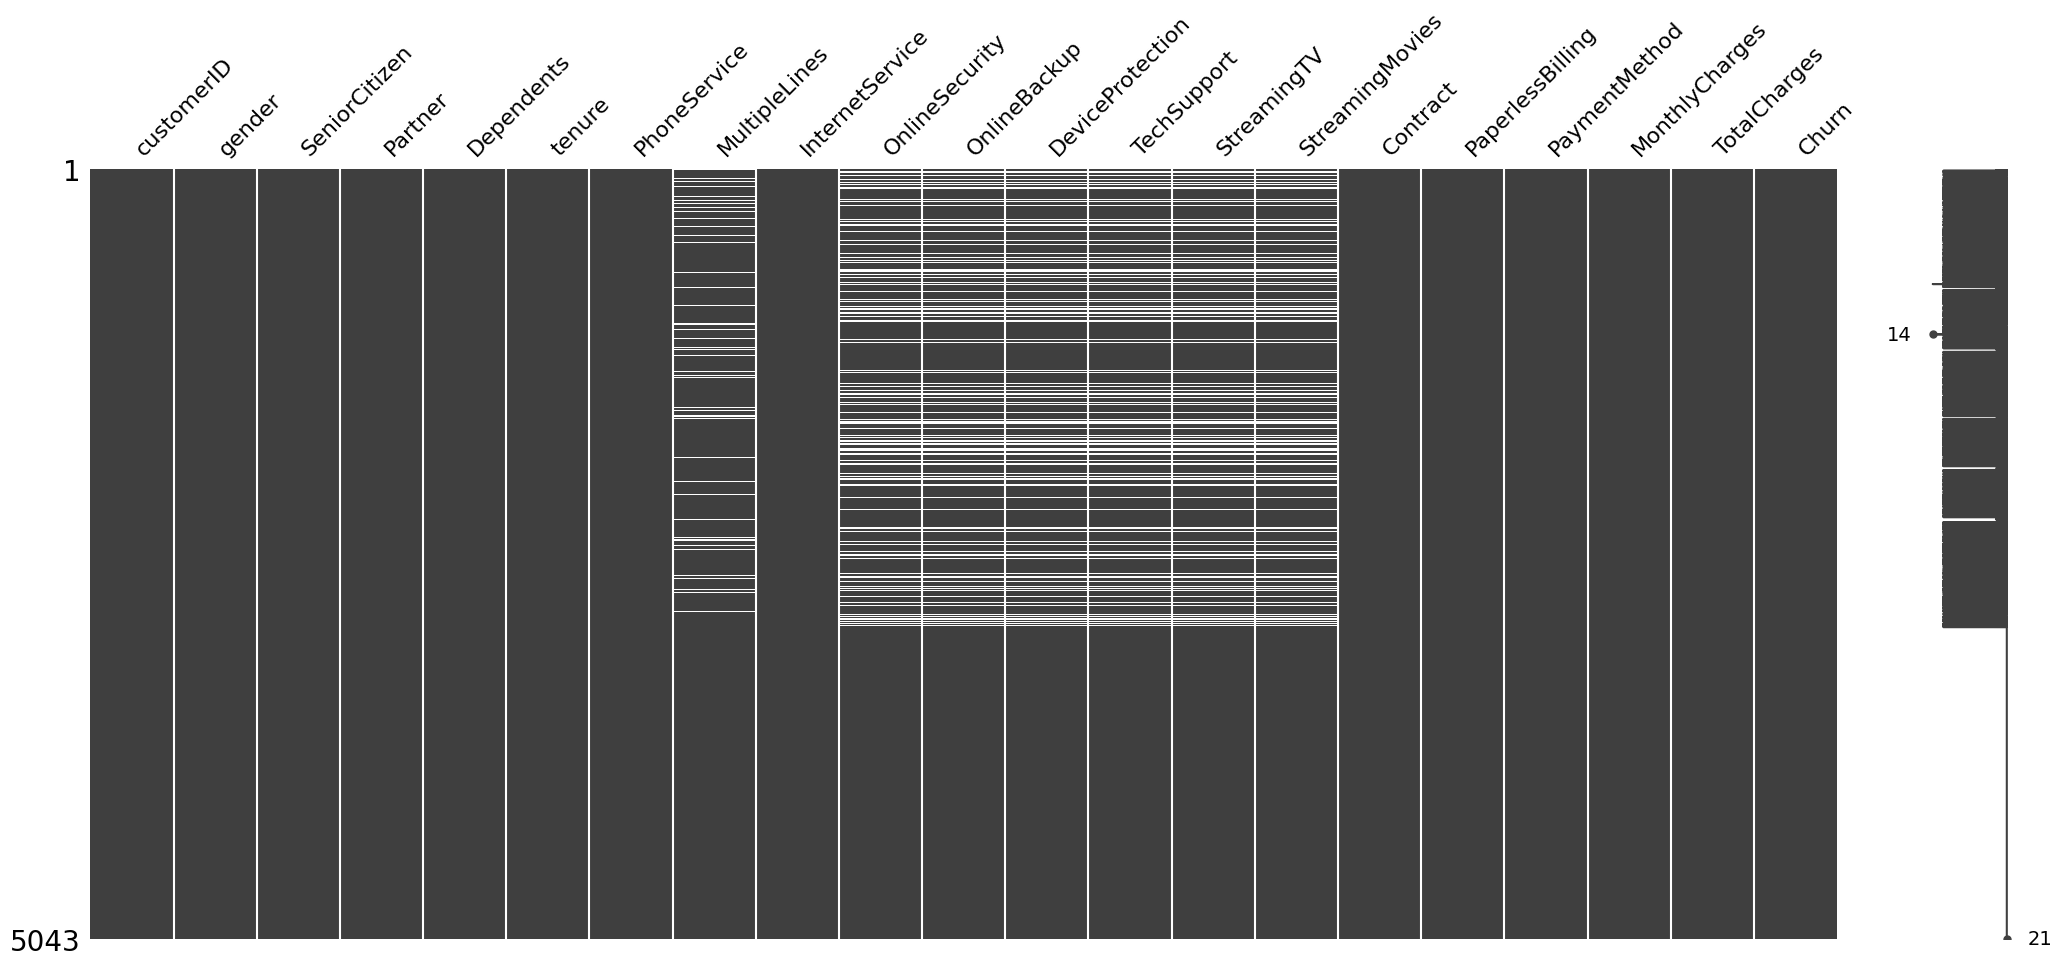

In [22]:
# Visualizing missing data pattern
msno.matrix(dn)

In [23]:
# Viewing the first few rows of MultipleLines
dn['MultipleLines'].head()

0    NaN
1     No
2     No
3    NaN
4     No
Name: MultipleLines, dtype: object

In [24]:
# Observing the unique values in the column
dn['MultipleLines'].value_counts()

MultipleLines
No                  2424
Yes                 2130
No phone service     220
Name: count, dtype: int64

In [25]:
# Filling null values
dn['MultipleLines'] = dn['MultipleLines'].fillna('No phone service')

In [26]:
colz = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',  'StreamingMovies']

# Filling null values across similar columns
dn[colz] = dn[colz].fillna('No internet service')
dn[colz]

,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,No,Yes,No,No,No,No
1,Yes,No,Yes,No,No,No
2,Yes,Yes,No,No,No,No
3,Yes,No,Yes,Yes,No,No
4,No,No,No,No,No,No
...,...,...,...,...,...,...
2038,Yes,No,Yes,Yes,Yes,Yes
2039,No,Yes,Yes,No,Yes,Yes
2040,Yes,No,No,No,No,No
2041,No,No,No,No,No,No


In [27]:
# Descriptive statistics of numerical columns
dn.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5043.0,0.162403,0.368857,0.0,0.000,0.000000,0.000000,1.000000
tenure,5043.0,32.576641,24.529807,0.0,9.000,29.000000,56.000000,72.000000
MonthlyCharges,5043.0,65.090214,30.068133,18.4,35.775,70.550003,90.050003,118.650002


In [28]:
# Datatype conversion for SeniorCitizen
dn['SeniorCitizen'] = dn['SeniorCitizen'].astype('object')

In [29]:
# Processing and converting TotalCharges column datatype
dn['TotalCharges'] = dn['TotalCharges'].str.strip().replace('', '0')
dn['TotalCharges'] = dn['TotalCharges'].round().astype('float')

In [30]:
# Descriptive statistics after changing datatypes
dn.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,5043.0,32.576641,24.529807,0.0,9.000,29.000000,56.000000,72.000000
MonthlyCharges,5043.0,65.090214,30.068133,18.4,35.775,70.550003,90.050003,118.650002
TotalCharges,2043.0,2299.832575,2261.993574,0.0,429.000,1393.600000,3846.100000,8670.100000


In [31]:
# Feature imputation for selected columns
coln = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',  'StreamingMovies']

# Initialize a dictionary to store the encoders and mappings
encoders = {}
mappings = {}

# Loop through each column, apply LabelEncoder, and store the encoder and mapping
for column in coln:
    le = LabelEncoder()  
    dn[column] = le.fit_transform(dn[column])  
    
    # Store the encoder for potential inverse transformation
    encoders[column] = le
    
    # Store the mapping of labels to encoded values
    mappings[column] = dict(zip(le.classes_, le.transform(le.classes_)))

# Print the encoded DataFrame
print("Encoded DataFrame:")
print(dn)

# Print the mappings for each column
print("\nLabel Mappings:")
for column, mapping in mappings.items():
    print(f"{column}: {mapping}")


Encoded DataFrame:
      customerID  gender SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female             0     Yes         No       1   
1     5575-GNVDE    Male             0      No         No      34   
2     3668-QPYBK    Male             0      No         No       2   
3     7795-CFOCW    Male             0      No         No      45   
4     9237-HQITU  Female             0      No         No       2   
...          ...     ...           ...     ...        ...     ...   
2038  6840-RESVB    Male             0     Yes        Yes      24   
2039  2234-XADUH  Female             0     Yes        Yes      72   
2040  4801-JZAZL  Female             0     Yes        Yes      11   
2041  8361-LTMKD    Male             1     Yes         No       4   
2042  3186-AJIEK    Male             0      No         No      66   

     PhoneService  MultipleLines InternetService  OnlineSecurity  ...  \
0              No              1             DSL               0  ...   
1     

In [32]:
# Categorical features imputation
imputer = KNNImputer(n_neighbors=2)

dn_imputed = imputer.fit_transform(dn[coln])
dn_imputed = pd.DataFrame(dn_imputed, columns=coln)
dn_imputed


,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,1.0,0.0,2.0,0.0,0.0,0.0,0.0
1,0.0,2.0,0.0,2.0,0.0,0.0,0.0
2,0.0,2.0,2.0,0.0,0.0,0.0,0.0
3,1.0,2.0,0.0,2.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
5038,2.0,2.0,0.0,2.0,2.0,2.0,2.0
5039,2.0,0.0,2.0,2.0,0.0,2.0,2.0
5040,1.0,2.0,0.0,0.0,0.0,0.0,0.0
5041,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# Decode the encoded DataFrame back to original labels
for column in coln:
    dn[column] = encoders[column].inverse_transform(dn[column])

dn[coln]

,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,No phone service,No,Yes,No,No,No,No
1,No,Yes,No,Yes,No,No,No
2,No,Yes,Yes,No,No,No,No
3,No phone service,Yes,No,Yes,Yes,No,No
4,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...
2038,Yes,Yes,No,Yes,Yes,Yes,Yes
2039,Yes,No,Yes,Yes,No,Yes,Yes
2040,No phone service,Yes,No,No,No,No,No
2041,Yes,No,No,No,No,No,No


#### UNIVARIATE ANALYSIS

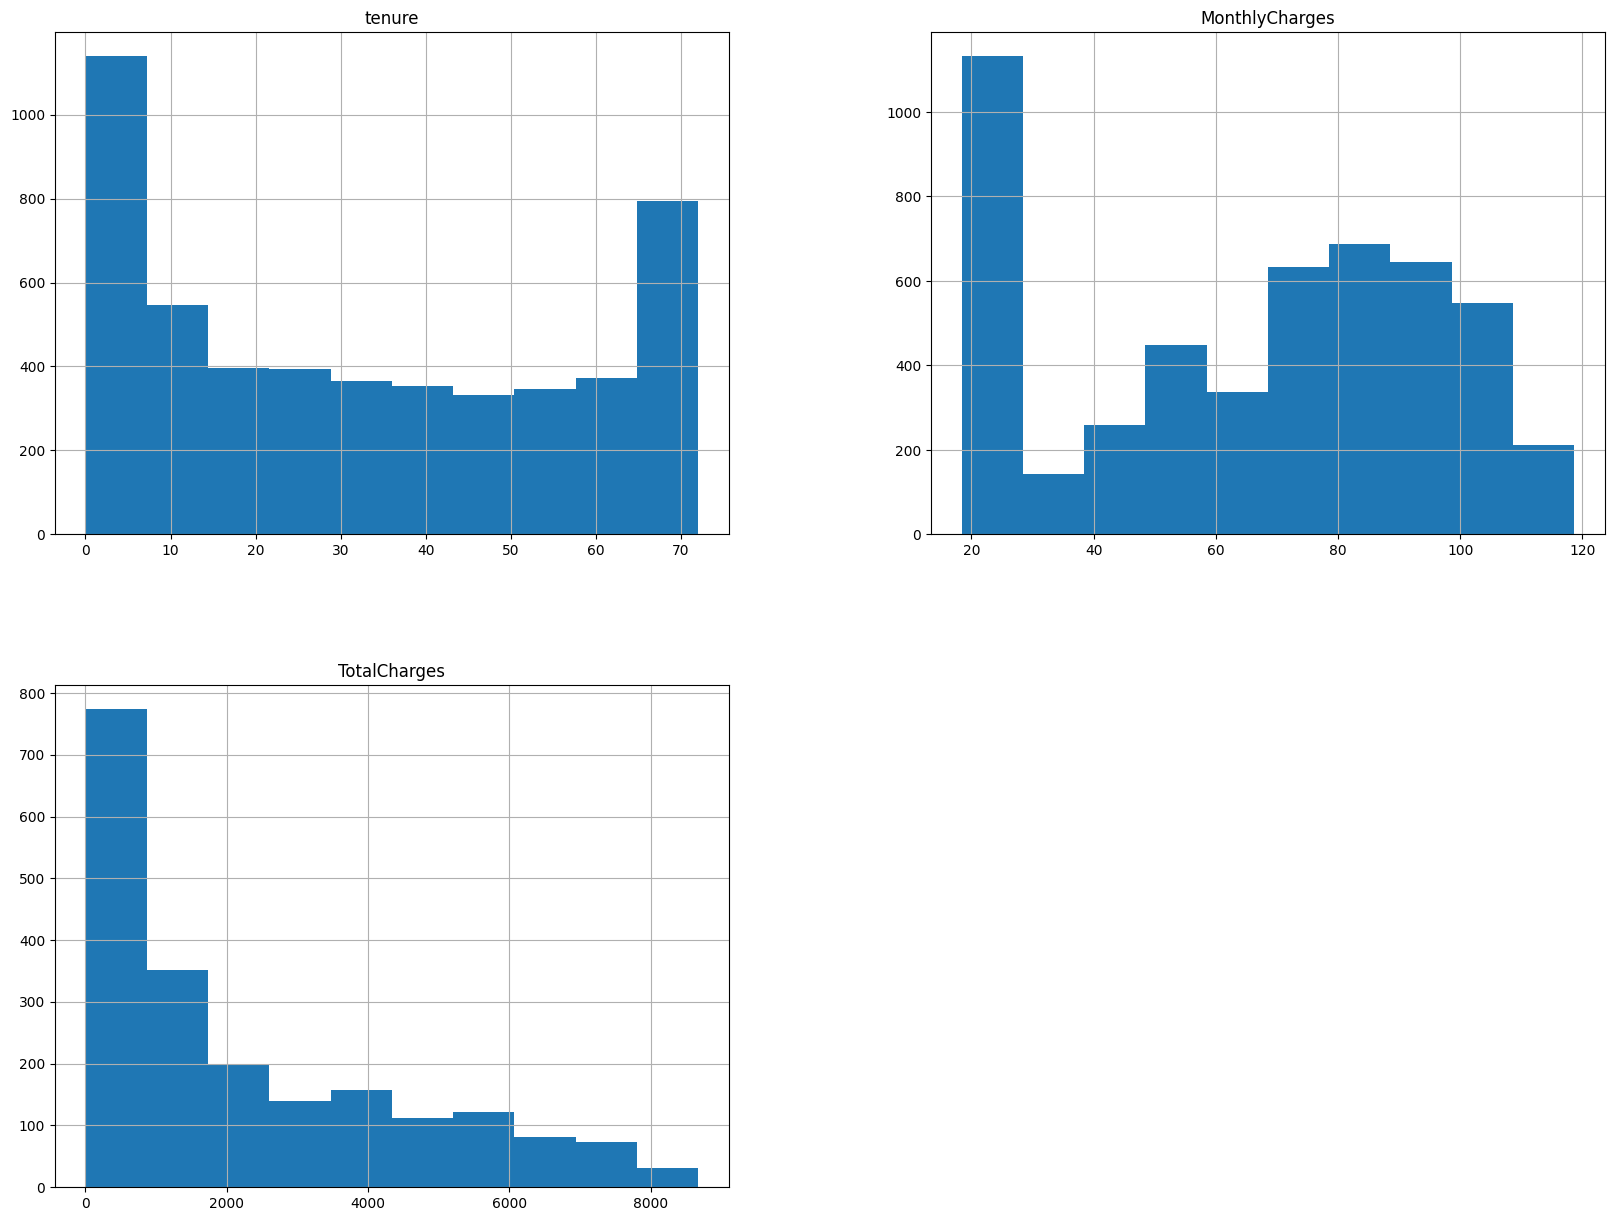

In [34]:
# Visualize the Distribution of numerical variables
dn.hist(figsize=(20, 15))
plt.show()

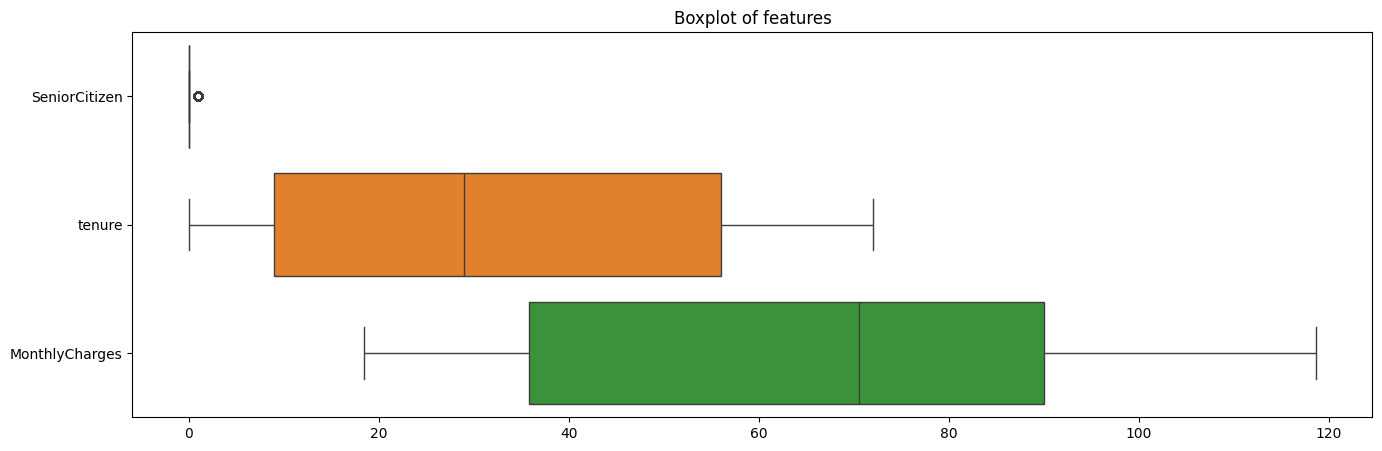

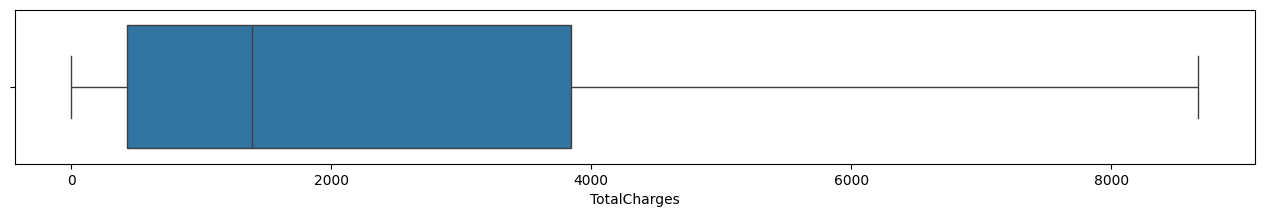

In [35]:
# Check for outliers in the data using boxplots
plt.figure(figsize=(16,5))
sns.boxplot(dn.drop(['TotalCharges'], axis=1), orient='h')
plt.title('Boxplot of features')


plt.figure(figsize=(16,2))
sns.boxplot(dn['TotalCharges'], orient='h')
plt.show()


#### BIVARIATE ANALYSIS

In [36]:
# Checking the correlation among numeric features
dn.corr(numeric_only=True).style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.240645,0.829524
MonthlyCharges,0.240645,1.000000,0.655388
TotalCharges,0.829524,0.655388,1.000000


In [37]:
dx = dn.groupby('Churn', as_index=False)['tenure'].sum()
dx_sorted = dx.sort_values(by='tenure', ascending=False)

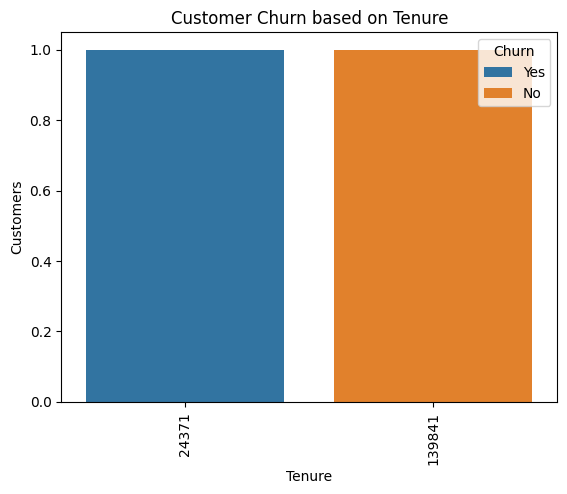

In [38]:
# Relationship beyween Customer Churn and Gender
sns.countplot(data=dx_sorted,x='tenure',hue='Churn')
plt.xlabel('Tenure')
plt.ylabel('Customers')
plt.title('Customer Churn based on Tenure')
plt.xticks(rotation=90)
plt.show()

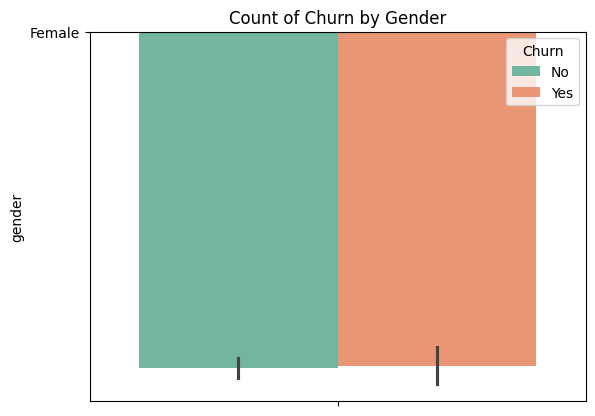

In [39]:
# Count plot of Gender and Churn
sns.barplot(y='gender', hue='Churn', data=dn, palette='Set2')
plt.title('Count of Churn by Gender')
plt.show()


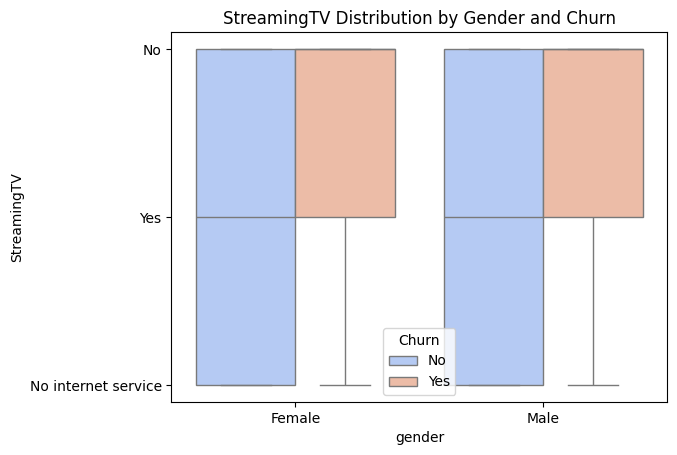

In [40]:
# Create a box plot for Age with Gender and Churn
sns.boxplot(x='gender', y='StreamingTV', hue='Churn', data=dn, palette="coolwarm")
plt.title('StreamingTV Distribution by Gender and Churn')
plt.show()


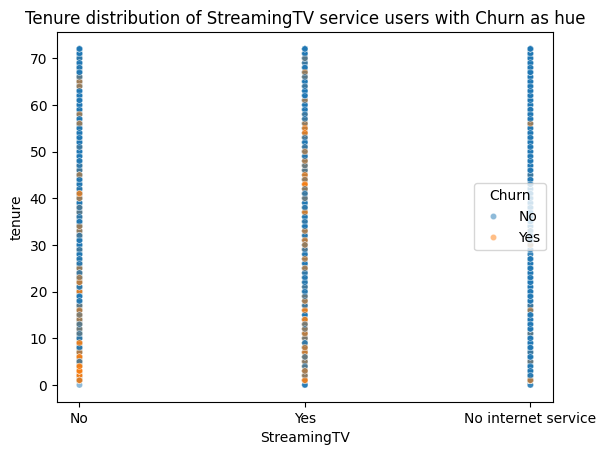

In [41]:
sns.scatterplot(x='StreamingTV', y='tenure', hue='Churn', data=dn, alpha=0.5, s=20)
plt.title('Tenure distribution of StreamingTV service users with Churn as hue')
plt.show()


FEATURE IMPORTANCE ANALYSIS

In [42]:
# Assume you have a pandas DataFrame 'df' and 'churn' is the target variable
features = dn.select_dtypes(include=['object', 'category']).columns  # Select categorical features
p_values = {}

for feature in features:
    crosstab = pd.crosstab(dn[feature], dn['Churn'])
    _, p_value, _, _ = chi2_contingency(crosstab)
    p_values[feature] = p_value

# Display features with their p-values
pd.Series(p_values).sort_values()


Churn                0.000000e+00
Contract            3.617896e-192
TechSupport         1.318564e-135
OnlineSecurity      1.130955e-133
InternetService     8.028682e-123
OnlineBackup         1.950173e-96
PaymentMethod        5.286904e-94
DeviceProtection     1.776218e-88
StreamingTV          5.308454e-60
StreamingMovies      2.090425e-59
PaperlessBilling     9.505182e-43
Dependents           5.285883e-34
SeniorCitizen        3.077113e-26
Partner              1.616863e-23
MultipleLines        1.457710e-02
PhoneService         3.279317e-01
customerID           4.933786e-01
gender               8.830796e-01
dtype: float64

In [43]:
dn[coln].isnull().sum()

MultipleLines       0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [44]:
dn.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,5043.0,32.576641,24.529807,0.0,9.000,29.000000,56.000000,72.000000
MonthlyCharges,5043.0,65.090214,30.068133,18.4,35.775,70.550003,90.050003,118.650002
TotalCharges,2043.0,2299.832575,2261.993574,0.0,429.000,1393.600000,3846.100000,8670.100000


In [45]:
dn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,NaN,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.950001,NaN,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,NaN,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,NaN,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,NaN,Yes


In [46]:
dn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   object 
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     5043 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    5043 non-null   object 
 10  OnlineBackup      5043 non-null   object 
 11  DeviceProtection  5043 non-null   object 
 12  TechSupport       5043 non-null   object 
 13  StreamingTV       5043 non-null   object 
 14  StreamingMovies   5043 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 
 17  

In [47]:
dn['TotalCharges'] = dn['TotalCharges'].replace(r'^\s*$', None, regex=True)

In [48]:
dn['TotalCharges'] = dn['TotalCharges'].round(2).astype('float')
dn['TotalCharges'] = dn['TotalCharges'].round(2)

In [49]:
dn['MonthlyCharges'] = dn['MonthlyCharges'].round(2)
dn['MonthlyCharges'].head()

0    29.85
1    56.95
2    53.85
3    42.30
4    70.70
Name: MonthlyCharges, dtype: float64

In [50]:
dn['Churn'] = dn['Churn'].fillna(dn['Churn'].mode()[0])

In [51]:
dn['TotalCharges'] = dn['TotalCharges'].fillna(dn['TotalCharges'].median())

<Axes: >

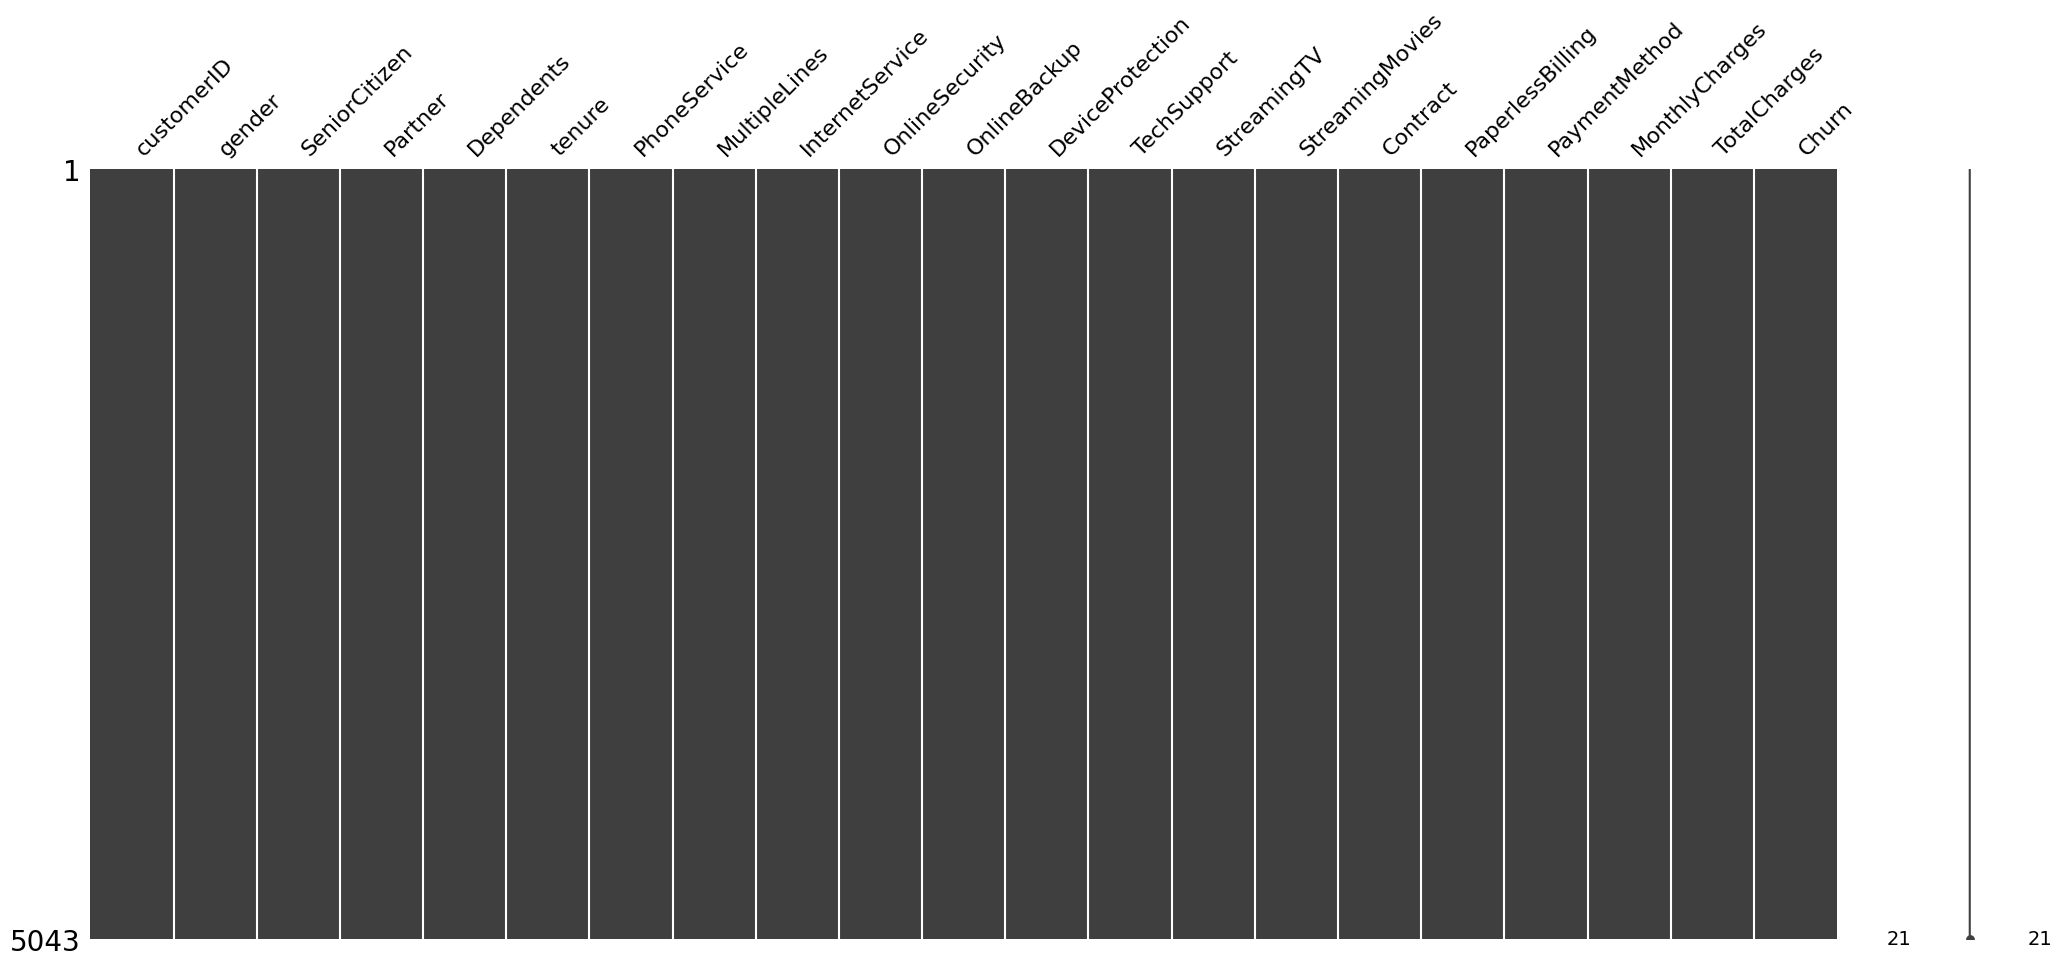

In [52]:
msno.matrix(dn)

### DATA TRANSFORMATION

In [53]:
num_cols = dn.select_dtypes(include=['number']).columns.tolist()
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [54]:
# List of numerical columns to apply the log transformation
columns_to_log = num_cols

# Apply log transformation (using log1p to handle zeros safely)
dn[columns_to_log] = dn[columns_to_log].apply(np.log1p)  # log1p(x) = log(1 + x)


In [55]:
dn[columns_to_log].head()

,tenure,MonthlyCharges,TotalCharges
0,0.693147,3.429137,7.240363
1,3.555348,4.059581,7.240363
2,1.098612,4.004602,7.240363
3,3.828641,3.768153,7.240363
4,1.098612,4.272491,7.240363


## ENCODING

In [56]:
# Step 1: Identify categorical and numerical columns
categorical_columns = dn.select_dtypes(include=['object', 'category']).columns

# Exclude 'customer_id' from the categorical columns list
categorical_columns = [col for col in categorical_columns if col != 'customerID']

# Identify numerical columns
numerical_columns = dn.select_dtypes(exclude=['object', 'category']).columns

# Step 2: Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_columns),  # One-hot encode categorical columns
        ('num', 'passthrough', numerical_columns)  # Leave numeric columns as they are
    ]
)

# Step 3: Apply the transformations
dn_encoded = preprocessor.fit_transform(dn)

# Step 4: Debugging: Check the shape of transformed data
print(f"Shape of transformed data: {dn_encoded.shape}")
print(f"Number of encoded categorical columns: {len(categorical_columns)}")
print(f"Number of numerical columns: {len(numerical_columns)}")

# Get feature names for the encoded categorical columns
encoded_categorical_columns = preprocessor.transformers_[0][1].get_feature_names_out(categorical_columns)

# Check the number of encoded categorical columns
print(f"Number of columns after one-hot encoding: {len(encoded_categorical_columns)}")

# Step 5: Combine the feature names for categorical and numerical columns
final_columns = list(encoded_categorical_columns) + list(numerical_columns)

# Ensure the number of columns matches the transformed data
if len(final_columns) != dn_encoded.shape[1]:
    raise ValueError(f"Mismatch between number of columns in final_columns ({len(final_columns)}) "
                     f"and the transformed data ({dn_encoded.shape[1]})")

# Step 6: Create the final DataFrame with the new encoded columns
encoded_dn = pd.DataFrame(dn_encoded, columns=final_columns)

# Display the final DataFrame
encoded_dn.head()


Shape of transformed data: (5043, 31)
Number of encoded categorical columns: 17
Number of numerical columns: 3
Number of columns after one-hot encoding: 28


,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes,tenure,MonthlyCharges,TotalCharges
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.693147,3.429137,7.240363
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.555348,4.059581,7.240363
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.098612,4.004602,7.240363
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.828641,3.768153,7.240363
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.098612,4.272491,7.240363


In [57]:
encoded_dn.head()

,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes,tenure,MonthlyCharges,TotalCharges
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.693147,3.429137,7.240363
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.555348,4.059581,7.240363
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.098612,4.004602,7.240363
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.828641,3.768153,7.240363
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.098612,4.272491,7.240363


In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame and 'target' is your target variable
P = encoded_dn.drop('Churn_Yes', axis=1)
q = encoded_dn['Churn_Yes']

# Split the data into training and testing sets
P_train, P_test, q_train, q_test = train_test_split(P, q, test_size=0.3, random_state=42)

# Fit a random forest classifier
model = RandomForestClassifier(random_state=42)
model.fit(P_train, q_train)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to view feature importances
importance_dn = pd.DataFrame({
    'Feature': P.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_dn[:9])


                           Feature  Importance
27                          tenure    0.204763
28                  MonthlyCharges    0.183661
29                    TotalCharges    0.103732
7      InternetService_Fiber optic    0.051146
25  PaymentMethod_Electronic check    0.035470
10              OnlineSecurity_Yes    0.032597
22               Contract_Two year    0.031843
0                      gender_Male    0.031067
23            PaperlessBilling_Yes    0.026537


In [59]:
importance_dn[:9].Feature.to_list()

['tenure',
 'MonthlyCharges',
 'TotalCharges',
 'InternetService_Fiber optic',
 'PaymentMethod_Electronic check',
 'OnlineSecurity_Yes',
 'Contract_Two year',
 'gender_Male',
 'PaperlessBilling_Yes']

# MODELLING AND EVALUATION

### DATA PREPARATION

In [60]:
# Definition of features (X) and target (y)
X = encoded_dn.drop('Churn_Yes', axis=1)

y = encoded_dn['Churn_Yes']

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### SVM MODEL

In [61]:
# Definition of SVM with class weights and hyperparameters
svm = SVC(max_iter=1000, class_weight='balanced')  # Added class_weight='balanced'

# Hyperparameter grid
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Training and hyperparameter tuning using GridSearchCV
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5, n_jobs=-1, scoring='f1_macro')  # Scoring metric adjusted
grid_search_svm.fit(X_train, y_train)

# Best estimator
svm_best = grid_search_svm.best_estimator_

# Predictions
y_pred_svm = svm_best.predict(X_test)

# Evaluation
print("SVM Best Hyperparameters:", grid_search_svm.best_params_)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("SVM Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))


SVM Best Hyperparameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
SVM Accuracy: 0.46878097125867196
SVM Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.35      0.49       734
         1.0       0.31      0.79      0.45       275

    accuracy                           0.47      1009
   macro avg       0.57      0.57      0.47      1009
weighted avg       0.68      0.47      0.48      1009

SVM Confusion Matrix:
 [[255 479]
 [ 57 218]]


C:\Users\Etebom\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


### RANDOM FOREST MODEL

In [62]:


# Definition of Random Forest with class weights and hyperparameters
rf = RandomForestClassifier(class_weight='balanced')  # Added class_weight='balanced'

# Hyperparameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Training and hyperparameter tuning using GridSearchCV
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1, scoring='f1_macro')  # Scoring metric adjusted
grid_search_rf.fit(X_train, y_train)

# Best estimator
rf_best = grid_search_rf.best_estimator_

# Predictions
y_pred_rf = rf_best.predict(X_test)

# Evaluation
print("Random Forest Best Hyperparameters:", grid_search_rf.best_params_)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Random Forest Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Accuracy: 0.7879088206144698
Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.81      0.85       734
         1.0       0.59      0.72      0.65       275

    accuracy                           0.79      1009
   macro avg       0.74      0.77      0.75      1009
weighted avg       0.81      0.79      0.79      1009

Random Forest Confusion Matrix:
 [[597 137]
 [ 77 198]]


### XGBOOST MODEL

In [63]:
# Calculate class weights manually
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])  # Ratio of majority to minority class

# Definition of XGBoost with class weights and hyperparameters
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight)  # Added scale_pos_weight

# Hyperparameter grid
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'subsample': [0.8, 1.0]
}

# Training and hyperparameter tuning using GridSearchCV
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, n_jobs=-1, scoring='f1_macro')  # Scoring metric adjusted
grid_search_xgb.fit(X_train, y_train)

# Best estimator
xgb_best = grid_search_xgb.best_estimator_

# Predictions
y_pred_xgb = xgb_best.predict(X_test)

# Evaluation
print("XGBoost Best Hyperparameters:", grid_search_xgb.best_params_)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


XGBoost Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50, 'subsample': 0.8}
XGBoost Accuracy: 0.7641228939544104
XGBoost Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.79      0.83       734
         1.0       0.55      0.69      0.61       275

    accuracy                           0.76      1009
   macro avg       0.71      0.74      0.72      1009
weighted avg       0.79      0.76      0.77      1009

XGBoost Confusion Matrix:
 [[581 153]
 [ 85 190]]


### KNN MODEL

In [64]:


# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)  # Resampling

# Definition of KNN with hyperparameters
knn = KNeighborsClassifier()

# Hyperparameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],  # 'distance' helps in handling imbalance
    'metric': ['euclidean', 'manhattan']
}

# Training and hyperparameter tuning using GridSearchCV
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, n_jobs=-1, scoring='f1_macro')  # Adjusted scoring
grid_search_knn.fit(X_train_resampled, y_train_resampled)  # Fit on resampled data

# Best estimator
knn_best = grid_search_knn.best_estimator_

# Predictions
y_pred_knn = knn_best.predict(X_test)

# Evaluation
print("KNN Best Hyperparameters:", grid_search_knn.best_params_)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))
print("KNN Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))


KNN Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
KNN Accuracy: 0.7224975222993062
KNN Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.77      0.80       734
         1.0       0.49      0.60      0.54       275

    accuracy                           0.72      1009
   macro avg       0.66      0.68      0.67      1009
weighted avg       0.74      0.72      0.73      1009

KNN Confusion Matrix:
 [[565 169]
 [111 164]]


### SUMMARY OF RESULTS

In [65]:
# Store results from all models
results = {
    'SVM': accuracy_score(y_test, y_pred_svm),
    'Random Forest': accuracy_score(y_test, y_pred_rf),
    'XGBoost': accuracy_score(y_test, y_pred_xgb),
    'KNN': accuracy_score(y_test, y_pred_knn)
}

# Print a summary table
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
print("\nSummary of Model Performance:")
print(results_df)



Summary of Model Performance:
           Model  Accuracy
0            SVM  0.468781
1  Random Forest  0.787909
2        XGBoost  0.764123
3            KNN  0.722498


SAVING THE MODELS

In [66]:
joblib.dump(svm, 'Churn_svm_model.pkl')
joblib.dump(rf, 'Churn_rf_model.pkl')
joblib.dump(xgb, 'Churn_xgb_model.pkl')
joblib.dump(knn, 'Churn_knn_model.pkl')

['Churn_knn_model.pkl']